## CSc 8830: Computer Vision - Assignment 3

1. Capture a 10 sec video footage using a camera of your choice. The footage should be taken with the camera in hand and you need to pan the camera slightly from left-right or right-left during the 10 sec duration. Pick any image frame from the 10 sec video footage. Pick a region of interest corresponding to an object in the image. Crop this region from the image. Then use this cropped region to compare with randomly picked 10 images in the dataset of 10 sec video frames, to see if there is a match for the object in the scenes from the 10 images. For comparison use sum of squared differences (SSD) or normalized correlation. 

Select ROI by clicking and dragging the mouse. Press 'q' to finish the selection.
ROI Selected...


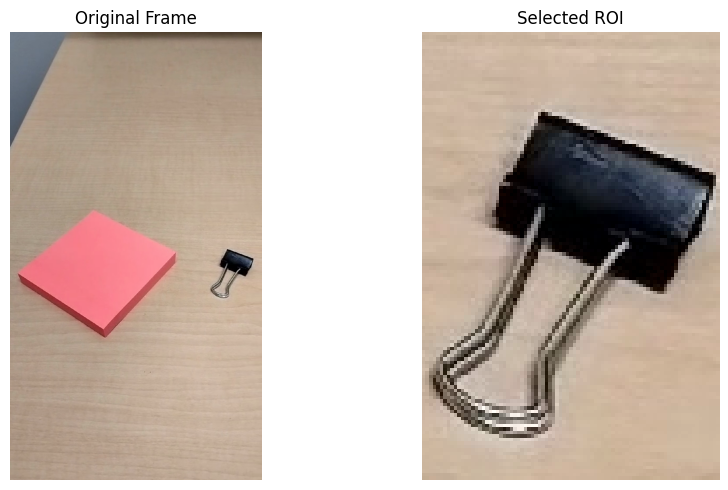

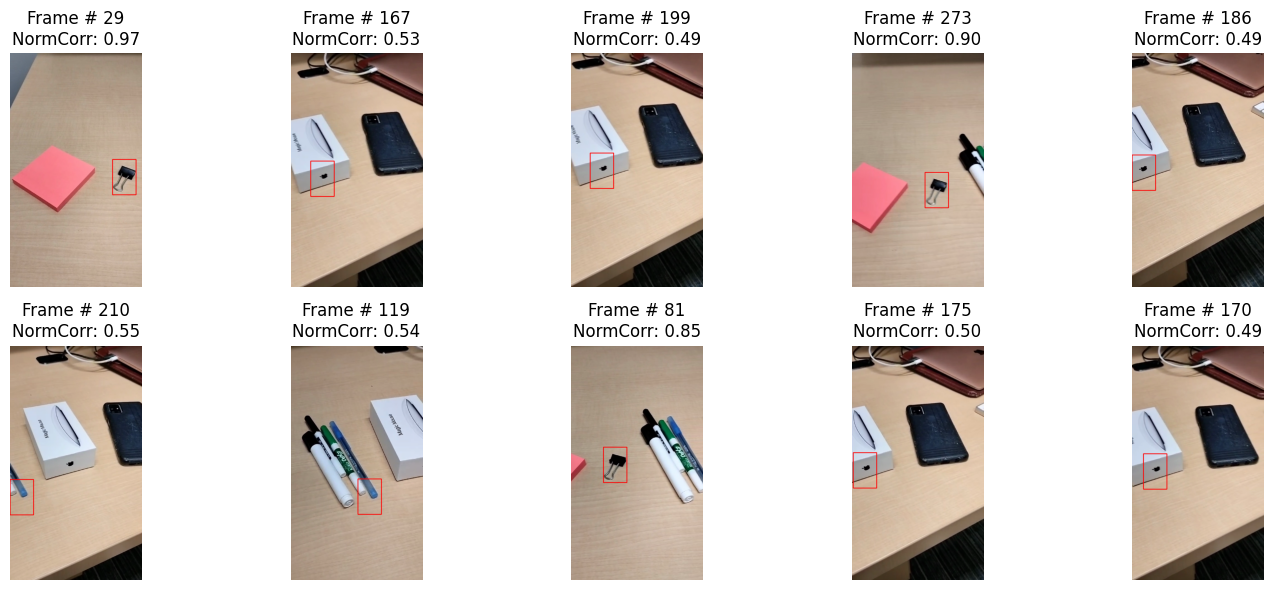

In [8]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Function to detect ORB keypoints and descriptors
def detect_keypoints_and_descriptors(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

# Function to compute Sum of Squared Differences (SSD) and find match location
def find_match_location_ssd(image1, image2):
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    result = cv2.matchTemplate(image1_gray, image2_gray, cv2.TM_SQDIFF_NORMED)
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    match_location = min_loc
    return match_location

# Function to compute normalized correlation
def compute_normalized_correlation(image1, image2):
    image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    corr = cv2.matchTemplate(image1_gray, image2_gray, cv2.TM_CCOEFF_NORMED)
    return np.max(corr)

# Global variables to store ROI coordinates
roi_x, roi_y, roi_width, roi_height = -1, -1, -1, -1
selecting_roi = False

# Mouse callback function to select ROI
def select_roi(event, x, y, flags, param):
    global roi_x, roi_y, roi_width, roi_height, selecting_roi

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_x, roi_y = x, y
        selecting_roi = True
    elif event == cv2.EVENT_MOUSEMOVE and selecting_roi:
        roi_width, roi_height = x - roi_x, y - roi_y
    elif event == cv2.EVENT_LBUTTONUP:
        roi_width, roi_height = x - roi_x, y - roi_y
        selecting_roi = False

# Load the original video
original_video = cv2.VideoCapture('cv-ass-3_video.mp4')

# Read a random frame from the video
total_frames = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_number = random.randint(0, total_frames)
original_video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = original_video.read()

# Create a window to select ROI
window_name = 'Select ROI (Press "q" to complete selection & quit)'
cv2.namedWindow(window_name)
cv2.setMouseCallback(window_name, select_roi)

# Select ROI
print("Select ROI by clicking and dragging the mouse. Press 'q' to finish the selection.")
while True:
    clone = frame.copy()
    if not selecting_roi and roi_width > 0 and roi_height > 0:
        cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 0, 255), 2)
    cv2.imshow(window_name, clone)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        print("ROI Selected...")
        break

# Close the window
cv2.destroyAllWindows()

# Define ROI
roi = frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

# Display the original frame and selected ROI
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original frame
axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Frame')
axes[0].axis('off')

# Display selected ROI
roi_frame = cv2.rectangle(frame.copy(), (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 0, 255), 2)
axes[1].imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
axes[1].set_title('Selected ROI')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Extract keypoints and descriptors for ROI
roi_keypoints, roi_descriptors = detect_keypoints_and_descriptors(roi)

# Load 10 random frames from the video
random_frames = []
random_frame_indices = random.sample(range(total_frames), 10)
correlations = []

for index in random_frame_indices:
    original_video.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, random_frame = original_video.read()
    random_frames.append(random_frame)
    correlation = compute_normalized_correlation(roi, random_frame)
    correlations.append(correlation)

# Compare the ROI keypoints with each random frame
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (random_frame, correlation) in enumerate(zip(random_frames, correlations)):
    match_location = find_match_location_ssd(random_frame, roi)
    random_frame_with_roi = cv2.rectangle(random_frame.copy(), match_location, 
                                            (match_location[0] + roi_width, match_location[1] + roi_height), 
                                            (0, 0, 255), 2)

    axes[i].imshow(cv2.cvtColor(random_frame_with_roi, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Frame # {random_frame_indices[i]}\nNormCorr: {correlation:.2f}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Release video capture
original_video.release()

2. Solve the following by hand (on paper or typed: Do not just copy it from literature)
 
    (a) Derive the motion tracking equation from fundamental principles. Select any 2 consecutive frames from the set from problem 1 and compute the motion function estimates.
     
    (b). Derive the procedure for performing Lucas-Kanade algorithm for motion tracking when the motion is known to be affine: u(x,y) = a1*x + b1*y + c1; v(x,y) = a2*x + b2*y + c2 (the numbers are subscripts, not power) 

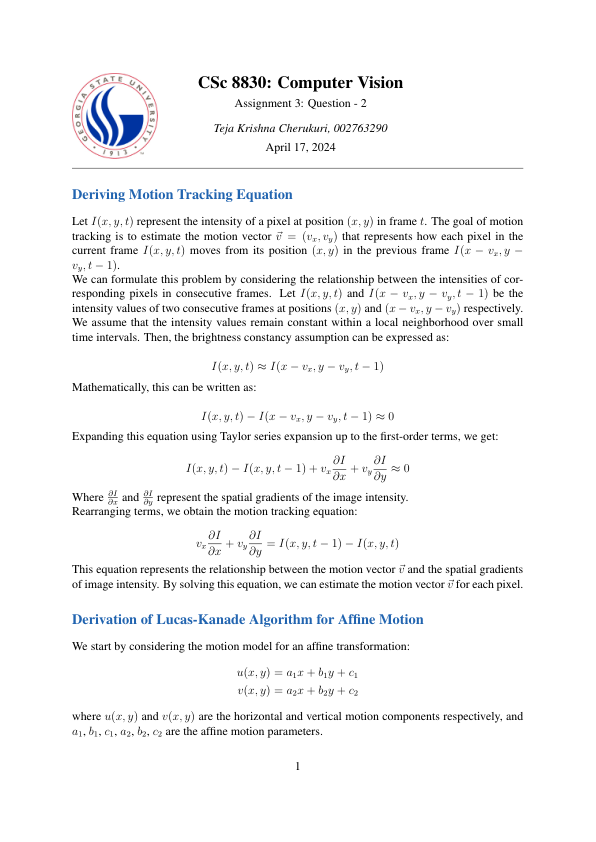

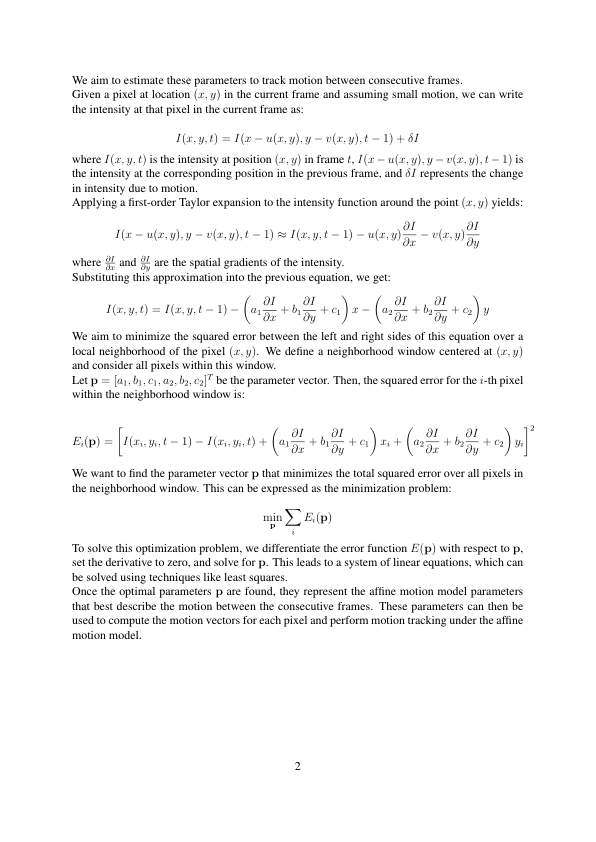

In [10]:
#!pip install pymupdf
import fitz  # PyMuPDF
from IPython.display import display, Image

def render_pdf_page(pdf_path, page_number):
    # Open the PDF
    pdf_document = fitz.open(pdf_path)

    # Select the desired page
    page = pdf_document.load_page(page_number - 1)

    # Render the page as an image (PNG)
    pix = page.get_pixmap()

    # Display the image in the notebook
    display(Image(data=pix.tobytes(), format='png'))

pdf_path = 'Assignment 3 - Q2.pdf'

# Specify the page number you want to render
page_number = 1
render_pdf_page(pdf_path, page_number)

# Specify the page number you want to render
page_number = 2
render_pdf_page(pdf_path, page_number)

3. Fix a marker on a wall or a flat vertical surface. From a distance D, keeping the camera stationed static (not handheld and mounted on a tripod or placed on a flat surface), capture an image such that the marker is registered. Then translate the camera by T units along the axis parallel to the ground (horizontal) and then capture another image, with the marker being registered. Compute D using disparity based depth estimation in stereo-vision theory. (Note: you can pick any value for D and T. Keep in mind that T cannot be large as the marker may get out of view. Of course this depends on D)

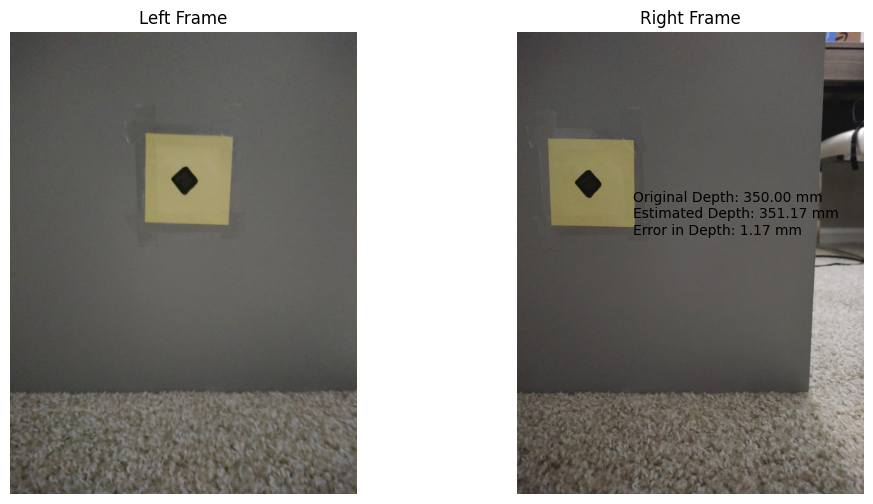

Estimated Depth D: 351.16779753671466 mm
Original Depth D: 350.0 mm


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_images(left_image_path, right_image_path):
    """Load the stereo images."""
    left_image = cv2.imread(left_image_path)
    right_image = cv2.imread(right_image_path)
    return left_image, right_image

def convert_to_grayscale(image):
    """Convert images to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def compute_disparity_map(left_gray, right_gray):
    """Compute disparity map."""
    stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=15)
    disparity = stereo.compute(left_gray, right_gray)
    return disparity

def calculate_depth(disparity_map, focal_length=35, translation=90):
    """Calculate depth."""
    disparity_value = np.mean(disparity_map)
    depth = (focal_length * translation) / disparity_value
    return depth

def plot_images_with_depth(left_image, right_image, depth, original_depth=35.0):
    """Plot the images with annotated depth."""
    plt.figure(figsize=(12, 6))

    # Plot the left image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
    plt.title('Left Frame')
    plt.axis('off')

    # Plot the right image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
    plt.title('Right Frame')
    plt.axis('off')

    # Annotate the estimated depth
    plt.text(400, 700, f"Original Depth: {original_depth*10:.2f} mm\nEstimated Depth: {depth*10:.2f} mm\nError in Depth: {(depth*10)-(original_depth*10):.2f} mm", color='black')

    plt.show()

    print("Estimated Depth D:", depth*10, "mm")
    print("Original Depth D:", original_depth*10, "mm")

left_image_path = 'mark-1.jpeg'
right_image_path = 'mark-2.jpeg'

left_image, right_image = load_images(left_image_path, right_image_path)
left_gray = convert_to_grayscale(left_image)
right_gray = convert_to_grayscale(right_image)

disparity_map = compute_disparity_map(left_gray, right_gray)
depth = calculate_depth(disparity_map)

plot_images_with_depth(left_image, right_image, depth)


4. For the video (problem 1) you have taken, plot the optical flow vectors on each frame using MATLAB’s optical flow codes. 

    (i) treating every previous frame as a reference frame 

    (ii) treating every 11th frame as a reference frame 
    
    (iii) treating every 31st frame as a reference frame 

    **Soved this problem using Matlab**

5. Run the feature-based matching object detection on the images from problem (1). MATLAB (not mandatory for this problem) Tutorial for feature-based matching object detection is available here: 
https://www.mathworks.com/help/vision/ug/object-detection-in-a-cluttered-scene-using-point-feature-matching.html 

Select ROI by clicking and dragging the mouse. Press 'q' to finish the selection.
ROI Selected...


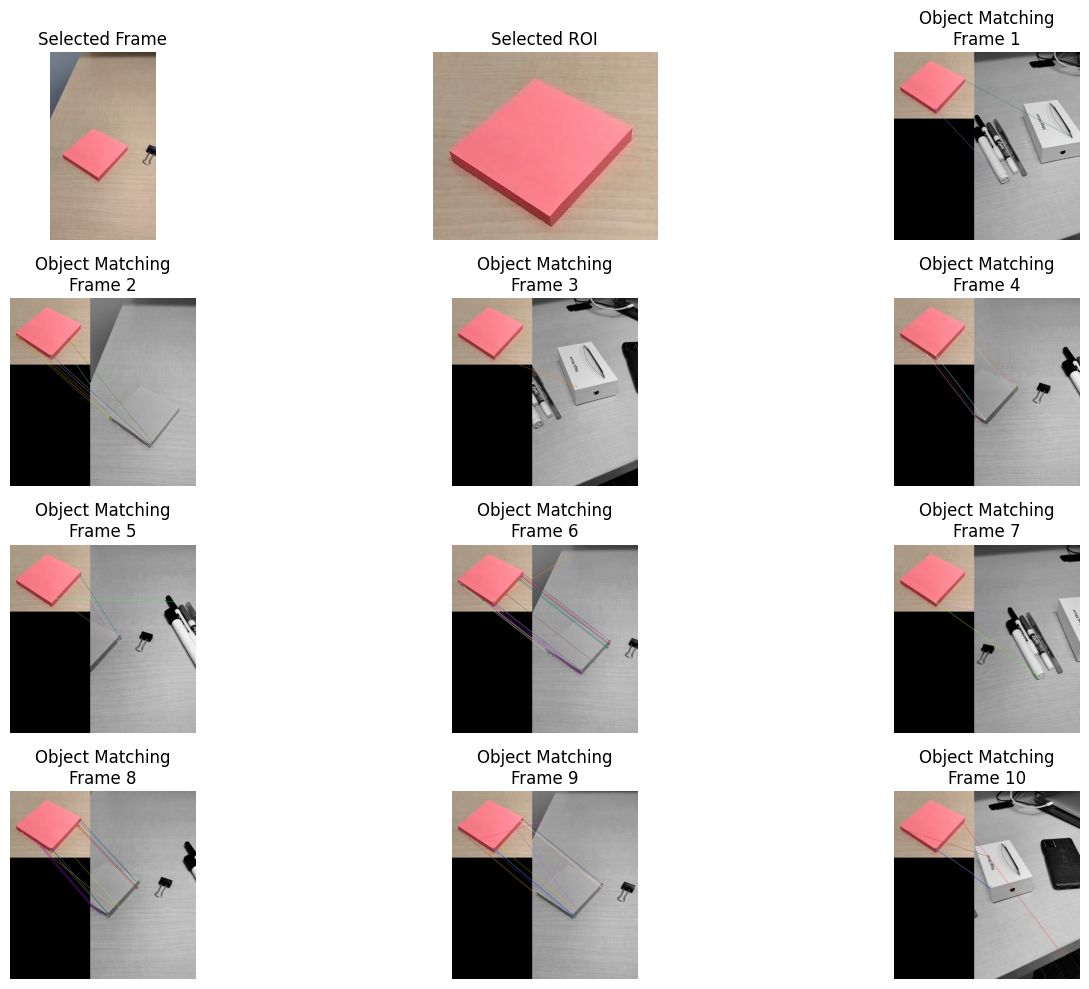

In [34]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def detect_objects_sift(selected_frame, selected_roi, frames):
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for selected ROI
    keypoints_roi, descriptors_roi = sift.detectAndCompute(selected_roi, None)

    matched_frames = []

    for frame in frames:
        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and compute descriptors for the frame
        keypoints_frame, descriptors_frame = sift.detectAndCompute(gray_frame, None)

        # Perform feature matching
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(descriptors_roi, descriptors_frame, k=2)

        # Apply ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        # Calculate SSD value for each match
        ssd_values = [m.distance for m in good_matches]

        # Calculate average SSD value
        avg_ssd = np.mean(ssd_values)

        # Draw matches
        matched_frame = cv2.drawMatches(selected_roi, keypoints_roi, gray_frame, keypoints_frame, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Append matched frame and average SSD value to the list
        matched_frames.append((matched_frame, avg_ssd))

    return matched_frames

def select_roi(event, x, y, flags, param):
    global roi_x, roi_y, roi_width, roi_height, selecting_roi

    if event == cv2.EVENT_LBUTTONDOWN:
        roi_x, roi_y = x, y
        selecting_roi = True
    elif event == cv2.EVENT_MOUSEMOVE and selecting_roi:
        roi_width, roi_height = x - roi_x, y - roi_y
    elif event == cv2.EVENT_LBUTTONUP:
        roi_width, roi_height = x - roi_x, y - roi_y
        selecting_roi = False

if __name__ == "__main__":
    original_video = cv2.VideoCapture('cv-ass-3_video.mp4')
    total_frames = int(original_video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_number = random.randint(0, total_frames)
    original_video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, selected_frame = original_video.read()

    window_name = 'Select ROI (Press "q" to complete selection & quit)'
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, select_roi)

    print("Select ROI by clicking and dragging the mouse. Press 'q' to finish the selection.")
    while True:
        clone = selected_frame.copy()
        if not selecting_roi and roi_width > 0 and roi_height > 0:
            cv2.rectangle(clone, (roi_x, roi_y), (roi_x+roi_width, roi_y+roi_height), (0, 0, 255), 2)
        cv2.imshow(window_name, clone)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            print("ROI Selected...")
            break

    selected_roi = selected_frame[roi_y:roi_y+roi_height, roi_x:roi_x+roi_width]

    random_frame_indices = random.sample(range(total_frames), 10)
    frames = []
    for index in random_frame_indices:
        original_video.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = original_video.read()
        frames.append(frame)

    matched_frames = detect_objects_sift(selected_frame, selected_roi, frames)

    plt.figure(figsize=(15, 10))
    plt.subplot(4, 3, 1)
    plt.imshow(cv2.cvtColor(selected_frame, cv2.COLOR_BGR2RGB))
    plt.title('Selected Frame')
    plt.axis('off')

    plt.subplot(4, 3, 2)
    plt.imshow(cv2.cvtColor(selected_roi, cv2.COLOR_BGR2RGB))
    plt.title('Selected ROI')
    plt.axis('off')

    for i, (matched_frame, avg_ssd) in enumerate(matched_frames):
        plt.subplot(4, 3, i+3)
        plt.imshow(cv2.cvtColor(matched_frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Object Matching\nFrame {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    original_video.release()


6. Refer to the Bag of Features example MATLAB source code provided in the classroom’s classwork page. In your homework, pick an object category that would be commonly seen in any household (e.g. cutlery) and pick 5 object types (e.g. for cutlery pick spoon, fork, butter knife, cutting knife, ladle). Present your performance evaluation. 

    **Soved this problem using Matlab**

7. Repeat the image capture experiment from problem (3), however, now also rotate (along the ground plane) the camera 2 (right camera) towards camera 1 position, after translation by T. Make sure the marker is within view. Note down the rotation angle. Run the tutorial provided for uncalibrated stereo rectification in here: https://www.mathworks.com/help/vision/ug/uncalibrated-stereo-image-rectification.html (MATLAB is mandatory for this exercise). Exercise this tutorial for the image pairs you have captured. You can make assumptions as necessary, however, justify them in your answers/description. (Note: you can print out protractors from any online source and place your cameras on that when running experiments: http://www.ossmann.com/protractor/conventional-protractor.pdf). 

    **Soved this problem using Matlab**

8. Implement a real-time object tracker (two versions) that (i) uses a marker (e.g. QR code or April tags), and (ii) does not use any marker and only relies on the object

In [41]:
# Generate QR Codes
import qrcode

object_list = ["Toy", "Laptop", "Chair", "Cup"]
qr_dir = "QR Codes/"
for object in object_list:
    code = qrcode.make(object)
    code.save(qr_dir+object+"QR.jpg")

Object Tracking with Marker (QR Code)

In [42]:
import cv2

camera_id = 0
delay = 1
window_name = 'Object Tracking with Marker (QR Code)'

qr_detector = cv2.QRCodeDetector()
cap = cv2.VideoCapture(camera_id)

def detect_and_draw_qr_codes(frame, detector):
    ret_qr, decoded_info, points, _ = detector.detectAndDecodeMulti(frame)
    if ret_qr:
        for s, p in zip(decoded_info, points):
            if s:
                # Draw rectangle
                frame = cv2.polylines(frame, [p.astype(int)], True, (255, 0, 0), 8)
                # Add text
                cv2.putText(frame, s, (int(p[0][0]), int(p[0][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            else:
                color = (0, 0, 255)
                frame = cv2.polylines(frame, [p.astype(int)], True, color, 8)
    return frame

while True:
    ret, frame = cap.read()

    if ret:
        frame = detect_and_draw_qr_codes(frame, qr_detector)
        cv2.imshow(window_name, frame)

    if cv2.waitKey(delay) & 0xFF == ord('q'):
        break

cv2.destroyWindow(window_name)


Object Tracker based on Object

In [39]:
import cv2
import math

class EuclideanDistTracker:
    def __init__(self):
        # Store the center positions of the objects
        self.center_points = {}
        # Keep the count of the IDs
        # each time a new object id detected, the count will increase by one
        self.id_count = 0


    def update(self, objects_rect):
        # Objects boxes and ids
        objects_bbs_ids = []

        # Get center point of new object
        for rect in objects_rect:
            x, y, w, h = rect
            cx = (x + x + w) // 2
            cy = (y + y + h) // 2

            # Find out if that object was detected already
            same_object_detected = False
            for id, pt in self.center_points.items():
                dist = math.hypot(cx - pt[0], cy - pt[1])

                if dist < 25:
                    self.center_points[id] = (cx, cy)
                    objects_bbs_ids.append([x, y, w, h, id])
                    same_object_detected = True
                    break

            # New object is detected we assign the ID to that object
            if same_object_detected is False:
                self.center_points[self.id_count] = (cx, cy)
                objects_bbs_ids.append([x, y, w, h, self.id_count])
                self.id_count += 1

        # Clean the dictionary by center points to remove IDS not used anymore
        new_center_points = {}
        for obj_bb_id in objects_bbs_ids:
            _, _, _, _, object_id = obj_bb_id
            center = self.center_points[object_id]
            new_center_points[object_id] = center

        # Update dictionary with IDs not used removed
        self.center_points = new_center_points.copy()
        return objects_bbs_ids

# Create tracker object
tracker = EuclideanDistTracker()

cap = cv2.VideoCapture("traffic-vehicles.mp4")

# Object detection from Stable camera
object_detector = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=40)

# Get the frame width and height
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('Object Tracking based-on Object.mp4', fourcc, 20.0, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Extract Region of interest
    roi = frame[340: 720,500: 800]

    # 1. Object Detection
    mask = object_detector.apply(roi)
    _, mask = cv2.threshold(mask, 254, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    detections = []
    for cnt in contours:
        # Calculate area and remove small elements
        area = cv2.contourArea(cnt)
        if area > 100:
            x, y, w, h = cv2.boundingRect(cnt)
            detections.append([x, y, w, h])

    # 2. Object Tracking
    boxes_ids = tracker.update(detections)
    for box_id in boxes_ids:
        x, y, w, h, id = box_id
        cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 0, 255), 3)

    out.write(frame)  # Write the frame to output video
    cv2.imshow("roi", roi)
    cv2.imshow("Frame", frame)
    cv2.imshow("Mask", mask)

    key = cv2.waitKey(30)
    if key == 27:
        break

# Release video capture and writer
cap.release()
out.release()
cv2.destroyAllWindows()
